In [ ]:
! pip install openai pandas scikit-learn nltk rouge-score

In [1]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score

In [2]:
import os

# Dataset Loading

In [3]:
df = pd.read_csv('../../../../Data/VisDoM-main/spiqa/spiqa.csv')

# Helper Functions

In [5]:
# Evaluation metrics
def compute_metrics(pred, true):
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_score = rouge.score(true, pred)['rougeL'].fmeasure

    bleu_score = sentence_bleu([true.split()], pred.split())
    exact_match = int(pred.strip().lower() == true.strip().lower())
    
    return {"bleu": bleu_score, "rougeL": rouge_score, "exact_match": exact_match}


# Runnning Answer Generation

## Text only

### Generation Function

In [4]:
BASE_URL= "http://192.168.1.56:1234/v1"

In [5]:
from openai import OpenAI

client = OpenAI(base_url=BASE_URL, api_key='lm-studio')


In [8]:

def generate_answer_mistral(question, caption):
    prompt = f"""Caption: {caption}

Please provide a brief and accurate final answer to the following question based on the above caption.

Question: {question}
Reasonnin: Reason for the answer
Answer: Final brief answer
"""

    response = client.chat.completions.create(
        model="mistral",  # make sure this matches your LM Studio model name
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=512,
    )
    
    return response.choices[0].message.content.strip()


In [ ]:

# 🔍 Example
caption = "Figure 4. Visualizations of the preferred inputs for different class units on layer fc8..."
question = "How many hyperparameter combinations were used for the random hyperparameter search?"

print(generate_answer_mistral(question, caption))



### Evaluation function

In [7]:
def evaluate_text_only_spiqa(df):
    results = []
    for idx, row in df.iterrows():
        question = row['question']
        caption = row['caption']  # assumes pre-extracted caption
        true_answer = row['answer']

        pred_answer = generate_answer_mistral(question, caption)
        metrics = compute_metrics(pred_answer, true_answer)

        results.append({
            "q_id": row['q_id'],
            "question": question,
            "true_answer": true_answer,
            "generated_answer": pred_answer,
            **metrics
        })

    return pd.DataFrame(results)

### Simple Example Run

In [7]:
caption = "Figure 4. Visualizations of the preferred inputs for different class units on layer fc8..."
question = "How many hyperparameter combinations were used for the random hyperparameter search?"

print(generate_answer_mistral(question, caption))

NotFoundError: Error code: 404 - {'error': {'message': 'No models loaded. Please load a model in the developer page or use the `lms load` command.', 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}

In [ ]:
example = {
    "question": "How many hyperparameter combinations were used for the random hyperparameter search?",
    "answer": "300 sets of possible hyperparameter combinations then choose four of them that complement each other well.",
    "caption": "To pick a reasonable set of hyperparameters for all methods at once, we ran a random hyperparameter search of 300 possible combinations and settled on four that complement each other well. The four selected combinations are listed in Table 1..."
}

# Run
question = example["question"]
caption = example["caption"]
true_answer = example["answer"]

generated = generate_answer_mistral(question, caption)
metrics = compute_metrics(generated, true_answer)

print("Q:", question)
print("Generated:", generated)
print("True:", true_answer)
print("Metrics:", metrics)

In [ ]:
row = df.iloc[0]
image_path = os.path.join("/your/images/folder", row["reference_figure"])
caption = row["caption"]
question = row["question"]
true_answer = row["answer"]

# LLaVA example
# gen_answer = generate_llava_answer(image_path, caption, question)

# Mistral example
gen_answer = generate_answer_mistral(caption, question)

print("Question:", question)
print("Generated:", gen_answer)
print("Gold:", true_answer)


### Batch based Running the Code

In [13]:
import pandas as pd
import os
from openai import OpenAI
from tqdm.auto import tqdm

# === Config ===
CSV_PATH = "../../../../Data/VisDoM-main/spiqa/spiqa.csv"
# IMAGE_FOLDER = "/path/to/your/image/folder"  # not used here, but kept for consistency
RESULTS_PATH = "../../../../Data/spiqa_eval/mistral_only"
BATCH_SIZE = 10

# === Connect to LM Studio ===
client = OpenAI(base_url="http://127.0.0.1:1235/v1", api_key="lm-studio")

In [11]:
# === Mistral generation function ===
def generate_mistral_answer(caption, question):
    prompt = f"Caption: {caption}\n\nPlease answer the following question based on the caption above:\nQuestion: {question}\n\nAnswer:"
    try:
        response = client.chat.completions.create(
            model="mistral",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=512,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"[Error] {str(e)}"

In [12]:
START_INDEX = 0  # Change this for each run: 0, 10, 20, etc.

In [ ]:
# === Ensure output folder exists ===
os.makedirs(RESULTS_PATH, exist_ok=True)
end_index = START_INDEX + BATCH_SIZE
batch_file = os.path.join(RESULTS_PATH, f"mistral_generated_batch_{START_INDEX}_{end_index}.csv")

In [ ]:

# === Load the dataset and select the batch ===
df = pd.read_csv(CSV_PATH)
batch_df = df.iloc[START_INDEX:end_index]

# === Process each row in the batch ===
results = []
for idx, row in tqdm(batch_df.iterrows()):
    generated = generate_mistral_answer(row["caption"], row["question"])
    results.append({
        "q_id": row["q_id"],
        "doc_id": row["doc_id"],
        "question": row["question"],
        "true_answer": row["answer"],
        "generated_answer": generated,
        "reference_figure": row["reference_figure"],
        "caption": row["caption"]
    })

# === Save batch results ===
pd.DataFrame(results).to_csv(batch_file, index=False)
print(f"Mistral batch saved to {batch_file}")


0it [00:00, ?it/s]

✅ Mistral batch saved to ../../../../Data/spiqa_eval/mistral_only\mistral_generated_batch_0_10.csv


mistral only 1st batch 

## Vision Model Function and Prompt

### Generation Function

In [8]:
import base64

def image_to_base64(image_path, size=(336, 336)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        return base64.b64encode(img.tobytes()).decode("utf-8")


In [9]:
from openai import OpenAI
import base64

client = OpenAI(base_url="http://127.0.0.1:1235/v1", api_key="lm-studio")

def generate_answer_llava(image_path, caption, question, prompt_template):
    prompt = prompt_template.replace("<caption>", caption).replace("<question>", question)

    # prompt = f"<image>\nCaption: {caption} Please provide a brief answer to the following question after looking into the input image and caption.\nQuestion: {question}.\nASSISTANT:"

    # Encode image to base64
    with open(image_path, "rb") as f:
        image_base64 = base64.b64encode(f.read()).decode("utf-8")

    messages = [{
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_base64}"}},
            {"type": "text", "text": prompt}
        ]
    }]
    
    response = client.chat.completions.create(
        model="llava-v1.5-7b@q5_k_m",  # replace with your model name
        messages=messages,
        temperature=0.7,
        max_tokens=512
    )

    return response.choices[0].message.content.strip()

### Evaluation Function

In [10]:
# Evaluation loop
def evaluate_generation(df, image_base_path):
    results = []
    for idx, row in df.iterrows():
        question = row['question']
        true_answer = row['answer']
        fig_ids = row.get('reference_figure', [])

        # Full paths to the referenced images
        image_paths = [f"{image_base_path}/{fig}" for fig in fig_ids if isinstance(fig, str)]

        # Generate using LLaVA
        pred_answer = generate_answer_llava(question, image_paths)
        
        metrics = compute_metrics(pred_answer, true_answer)
        results.append({
            "q_id": row['q_id'],
            "question": question,
            "true_answer": true_answer,
            "generated_answer": pred_answer,
            **metrics
        })
    
    return pd.DataFrame(results)

### Simple Example Run

In [ ]:
IMG_FOLDER_PATH = "../../../../Data/spiqa/test-B/Images/SPIQA_testB_Images/SPIQA_testB_Images/"

In [23]:
caption = "Figure 4. Visualizations of the preferred inputs for different class units on layer fc8..."
question = "How many hyperparameter combinations were used for the random hyperparameter search?"
image_path = IMG_FOLDER_PATH+"1b5a24639fa80056d1a17b15f6997d10e76cc731/7-Figure4-1.png"

_PROMPT = """<image>\n Caption: <caption> Please provide a brief answer to the following question after looking into the input image and caption. Question: <question>.\nASSISTANT:"""

answer = generate_answer_llava(image_path, caption, question, _PROMPT)
print("Answer:", answer)


Answer: The text in the image is not clear enough to discern the number of hyperparameter combinations that were used for the random hyperparameter search.


In [19]:
image_path = IMG_FOLDER_PATH+"1b5a24639fa80056d1a17b15f6997d10e76cc731/7-Figure4-1.png"
caption = "Figure 4. Visualizations of the preferred inputs for different class units on layer fc8..."
question = "How many hyperparameter combinations were used for the random hyperparameter search?"

print(generate_answer_llava(image_path, caption, question))

25


In [31]:
row = df.iloc[0]
image_path = os.path.join("../../../../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images",row['doc_id'], row["reference_figure"])
caption = row["caption"]
question = row["question"]
true_answer = row["answer"]

# LLaVA example
gen_answer = generate_answer_llava(image_path, caption, question, _PROMPT)

# Mistral example
# gen_answer = generate_mistral_answer(caption, question)

print("Question:", question)
print("Generated:", gen_answer)
print("Gold:", true_answer)


Question:  

What is the difference between the original and pre-processed SMD Navigate data? 
Generated: The original SMD Navigate data contains unstructured textual information, which is difficult to process and analyze. On the other hand, the pre-processed SMD Navigate data has been transformed into a structured format that can be easily understood and analyzed. This transformation involves steps such as tokenization, lemmatization, stemming or stopword removal, and converting the text into numerical vectors suitable for machine learning algorithms. By doing so, the pre-processed data becomes more accessible and easier to work with, which facilitates tasks like classification or clustering of the textual content in the dataset.
Gold:  

The pre-processed SMD Navigate data combines all the properties (such as distance, address) of a point of interest (POI) into a single subject with the object being "poi". The original data had separate entries for each property. 


### Total Answer Generation for -SPIQA - ViSDOMRAG

In [ ]:
# Load modified SPIQA DataFrame here:
df = pd.read_csv("../../../../Data/VisDoM-main/spiqa/spiqa.csv")  # or .json, or load however you have it

_PROMPT = """<image>\n Caption: <caption> Please provide a brief answer to the following question after looking into the input image and caption. Question: <question>.\nASSISTANT:"""

# Path to image folder
image_folder = "../../../../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"

# Evaluate all rows
results = []
for idx, row in df.iterrows():
    image_path = os.path.join(image_folder,row['doc_id'], row["reference_figure"])
    generated = generate_answer_llava(image_path, row["caption"], row["question"],_PROMPT)
    results.append({
        "q_id": row["q_id"],
        "doc_id": row["doc_id"],
        "question": row["question"],
        "true_answer": row["answer"],
        "generated_answer": generated,
        "reference_figure": row["reference_figure"],
        "caption": row["caption"]
    })

# Save to CSV or further process
results_df = pd.DataFrame(results)
results_df.to_csv("llava_generated_answers_spiqa_visdom_vision.csv", index=False)


: 

### Batchwise Generation for LLava SpiQA

In [5]:
from tqdm.auto import tqdm

In [1]:
import pandas as pd
import os
import base64
from openai import OpenAI

client = OpenAI(base_url="http://127.0.0.1:1235/v1", api_key="lm-studio")

# === Config ===
CSV_PATH = "../../../../Data/VisDoM-main/spiqa/spiqa.csv"
RESULTS_PATH = "../../../../Data/spiqa_eval/llava_only"
IMAGE_FOLDER = "../../../../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"


In [2]:

# === Prompt ===
_PROMPT = """<image>\n Caption: <caption> Please provide a brief answer to the following question after looking into the input image and caption. Question: <question>.\nASSISTANT:"""

# === Generation Function ===
def generate_answer_llava(image_path, caption, question, prompt_template):
    prompt = prompt_template.replace("<caption>", caption).replace("<question>", question)
    try:
        with open(image_path, "rb") as f:
            image_b64 = base64.b64encode(f.read()).decode("utf-8")
    except FileNotFoundError:
        return "[Image not found]"

    try:
        response = client.chat.completions.create(
            model="llava",
            messages=[{
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}},
                    {"type": "text", "text": prompt}
                ]
            }],
            temperature=0.7,
            max_tokens=512,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"[Error] {str(e)}"


In [3]:
BATCH_SIZE = 10
START_INDEX = 0  # Change this for each run: 0, 10, 20...


In [6]:

# === Load Data ===
df = pd.read_csv(CSV_PATH)
end_index = min(START_INDEX + BATCH_SIZE, len(df))
batch_df = df.iloc[START_INDEX:end_index]

# === Process Batch ===
results = []
for idx, row in tqdm(batch_df.iterrows()):
    
    image_path = os.path.join(IMAGE_FOLDER, row['doc_id'], row["reference_figure"])
    generated = generate_answer_llava(image_path, row["caption"], row["question"], _PROMPT)
    results.append({
        "q_id": row["q_id"],
        "doc_id": row["doc_id"],
        "question": row["question"],
        "true_answer": row["answer"],
        "generated_answer": generated,
        "reference_figure": row["reference_figure"],
        "caption": row["caption"]
    })


0it [00:00, ?it/s]

In [ ]:

# === Save Batch ===
os.makedirs(RESULTS_PATH, exist_ok=True)
batch_file = os.path.join(RESULTS_PATH,f"llava_generated_batch_{START_INDEX}_{end_index}.csv")
pd.DataFrame(results).to_csv(batch_file, index=False)
print(f"Batch saved to {batch_file}")


✅ Batch saved to ../../../../Data/spiqa_eval/llava_only\llava_generated_batch_0_10.csv


---

# Vision enabled LLM reasoning pipeline

Due to the computational limitations the llm reasoning and vision tasks are run seperately for the evaluation purposess.

### LLM reasoning and MLLLM vision response, LLM final answer Function defining

### Load data and Run Pipeline

In [ ]:



# === RUN PIPELINE ===
results = []

for idx, row in tqdm(batch_df.iterrows()):
    try:
        image_path = os.path.join(IMAGE_FOLDER, row["doc_id"], row["reference_figure"])
        caption = row["caption"]
        question = row["question"]
        true_answer = row["answer"]

        # Step 1: Mistral decides
        decision = mistral_decide_if_vision_needed(caption, question)

        if decision["needs_vision"]:
            sub_q = decision.get("sub_question", "")
            print(f"[{idx}] Mistral asked LLaVA: {sub_q}")
            vision_response = llava_respond(image_path, sub_q)
            print(f"[{idx}] LLaVA responded: {vision_response}")
            final_answer = mistral_combine_final_answer(caption, question, vision_response)
        else:
            final_answer = decision.get("final_answer", "[No answer]")

        results.append({
            "q_id": row["q_id"],
            "doc_id": row["doc_id"],
            "question": question,
            "true_answer": true_answer,
            "mistral_final_answer": final_answer,
            "used_vision": decision["needs_vision"],
            "sub_question": decision.get("sub_question", ""),
            "vision_answer": vision_response if decision["needs_vision"] else "",
            "reference_figure": row["reference_figure"],
            "caption": caption
        })

    except Exception as e:
        print(f"[{idx}] Error: {e}")
        continue

# === SAVE RESULTS ===
out_file = os.path.join(RESULTS_PATH, f"agent_pipeline_batch_{START_INDEX}_{end_index}.csv")
pd.DataFrame(results).to_csv(out_file, index=False)
print(f"Saved batch to: {out_file}")


0it [00:00, ?it/s]

[0] Mistral asked LLaVA: A detailed comparison of the original and pre-processed SMD Navigate data as described in Figure 9 of the Mem2Seq paper
[0] LLaVA responded: [Image not found]
✅ Saved batch to: ../../../../Data/spiqa_eval/agent_pipeline_batches\agent_pipeline_batch_0_5.csv


# Stagewise Running - for evaluation

## Function defining

In [ ]:
import re
import os, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import base64
from io import BytesIO
from PIL import Image


In [12]:
# === CLIENT SETUP ===
def load_client(BASE_URL):
    return OpenAI(base_url=BASE_URL, api_key="lm-studio")

# === UTILS ===
def image_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [13]:
# === STAGE 1: MISTRAL REASONING ===
def mistral_decide_if_vision_needed(caption, question):
    client = load_client(port=1234)  # mistral
    prompt = f"""
You are a scientific assistant. Your job is to determine whether answering the following question requires looking at a figure or table or other visual reference in the paper.
The sub_question is what you want to know about that visual element(figure, table, graph, chart, etc)
Caption:
{caption}

Question:
{question}

Reply in this JSON format:
{{
  "needs_vision": true/false,
  "sub_question": "...",
  "final_answer": "..."  // only if no vision is needed
}}
"""
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=700
    )
    return json.loads(response.choices[0].message.content)

# === STAGE 2: LLaVA VISION RESPONSE ===
def llava_respond(image_path, sub_question):
    client = load_client(port=1235)  # llava
    if not os.path.exists(image_path):
        return "[Image not found]"

    with Image.open(image_path) as img:
        image_b64 = image_to_base64(img)

    prompt = f"Please answer this question based on the image: {sub_question}"
    response = client.chat.completions.create(
        model="llava",
        messages=[{
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}},
                {"type": "text", "text": prompt}
            ]
        }],
        temperature=0.3,
        max_tokens=500,
    )
    return response.choices[0].message.content.strip()

# === STAGE 3: MISTRAL FINAL ANSWER ===
def mistral_combine_final_answer(caption, question, vision_response):
    client = load_client(port=1234)
    prompt = f"""
You are given a caption from a scientific paper, a user question, and a visual response from your assistant.

Caption:
{caption}

Question:
{question}

Visual Assistant's Answer:
{vision_response}

Use all this information to provide a final answer to the user's question.
Answer:
"""
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5,
        max_tokens=512,
    )
    return response.choices[0].message.content.strip()


In [ ]:
import os
import json
import pandas as pd

# === CONFIG ===
RESULTS_FOLDER = "./outputs/agent_pipeline_batches"
STAGE1_OUT = os.path.join(RESULTS_FOLDER, "reasoning_batch.json")
STAGE2_OUT = os.path.join(RESULTS_FOLDER, "vision_batch.json")
STAGE3_OUT = os.path.join(RESULTS_FOLDER, "final_output.csv")

# === Load stage 2 results (after vision stage) ===
with open(STAGE2_OUT, "r") as f:
    stage2_results = json.load(f)

# === Simulate Stage 3: Combine answers ===
final_output = []

for row in stage2_results:
    if row["needs_vision"]:
        # Placeholder logic for combining with vision answer
        final = f"[Combined] {row['vision_answer']}"
    else:
        final = row["direct_answer"]
    
    row["final_answer"] = final
    final_output.append(row)

# === Save final output to CSV ===
df_final = pd.DataFrame(final_output)
os.makedirs(os.path.dirname(STAGE3_OUT), exist_ok=True)
df_final.to_csv(STAGE3_OUT, index=False)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Final Answer Output", dataframe=df_final)


In [14]:
# CONFIG == Stage 1
CSV_PATH = "../../../../Data/VisDoM-main/spiqa/spiqa.csv" # VIsDOM questions


OUTPUT_FOLDER = '../../../../Data/spiqa_eval/agent_pipeline_batches/visdomrag' 
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_PATH =  os.path.join(OUTPUT_FOLDER, f"reasoning_batch_{START_INDEX}_{end_index}.json")

# === CONFIG === Stage 2
# CSV_PATH = "../../../../Data/VisDoM-main/spiqa/spiqa.csv"
IMAGE_FOLDER = "../../../../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"
RESULTS_PATH = "../../../../Data/spiqa_eval/agent_pipeline_batches/visdomrag"
os.makedirs(RESULTS_PATH, exist_ok=True)

BATCH_SIZE = 10


NameError: name 'START_INDEX' is not defined

In [ ]:
# === LOAD DATA ===
START = 0
END = min(START_INDEX + BATCH_SIZE, len(df))
def get_sav_json_
df = pd.read_csv(CSV_PATH).iloc[START:END]

# batch_df = df.iloc[START:END]

### Stage 1: code function : LLM Reasoning

In [ ]:
def mistral_decide_if_vision_needed(caption, question, debug=False):
    import re
    import json

    client = load_client(port=1234)

    prompt = f"""
You are a scientific assistant. Your job is to determine whether answering the following question requires looking at a figure or table or other visual reference in the paper.

The sub_question is what you want to know about that visual element (figure, table, graph, chart, etc) from your assistant.

Caption:
{caption}

Question:
{question}

Reply in this JSON format:
{{
  "needs_vision": true/false,
  "sub_question": "...",
  "final_answer": "..."  // only if no vision is needed
}}
"""

    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=700,
    )

    content = response.choices[0].message.content.strip()
    if debug:
        print("\nRaw Mistral Output:\n", content)

    # Remove code block markers
    content = re.sub(r"```json|```", "", content).strip()

    # Extract JSON block
    match = re.search(r"\{.*?\}", content, re.DOTALL)
    if not match:
        raise ValueError(f"Could not extract JSON from Mistral response:\n{content}")

    json_str = match.group()

    # Escape lone backslashes not already escaped
    json_str = re.sub(r'(?<!\\)\\(?![\\nrt"\\/bfu])', r'\\\\', json_str)

    try:
        parsed = json.loads(json_str)
        if not all(k in parsed for k in ["needs_vision", "sub_question", "final_answer"]):
            raise ValueError("Parsed JSON is missing required keys.")
        return parsed
    except json.JSONDecodeError as e:
        print("JSON decoding failed:")
        print(json_str)
        raise e


In [89]:
try:
    decision = mistral_decide_if_vision_needed(row.caption, row.old_question)
except Exception as e:
    print(f"[{row.q_id}] Failed to parse decision: {e}")
    decision = {
        "needs_vision": False,
        "sub_question": "",
        "final_answer": "[Error: Could not process the input]"
    }


In [90]:
results = []
for _, row in tqdm(df.iterrows()):
    try:
        decision = mistral_decide_if_vision_needed(row.caption, row.old_question)
    except Exception as e:
        print(f"[{row.q_id}] Failed to parse decision: {e}")
        decision = {
            "needs_vision": False,
            "sub_question": "",
            "final_answer": "[Error: Could not process the input]"
        }
    # decision = mistral_decide_if_vision_needed(row.caption, row.old_question) #old_question because the dataset is missed the field names
    results.append({
        "q_id": row.q_id,
        "doc_id": row.doc_id,
        "question": row.old_question,
        "caption": row.caption,
        "answer": row.answer,
        "reference_figure": row.reference_figure,
        "needs_vision": decision["needs_vision"],
        "sub_question": decision.get("sub_question", ""),
        "direct_answer": decision.get("final_answer", "")
    })
    print("decision: ", decision)
    print("caption: ", row.caption)
    print("question: ", row.old_question)

0it [00:00, ?it/s]

decision:  {'needs_vision': True, 'sub_question': 'The sub-question aims to understand the specific changes made to point-of-interest properties in the original and pre-processed SMD Navigate datasets as illustrated in Figure 9.', 'final_answer': "I'm unable to provide a final answer without visually inspecting Figure 9. The figure likely shows various transformations or modifications applied during the pre-processing stage of the SMD Navigate data."}
caption:  Figure 9: Pre-processing of SMD Navigate data used in Mem2Seq paper
question:  How does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?
decision:  {'needs_vision': True, 'sub_question': 'To determine the influence of increasing β2 on the trade-off between precision and recall in the salient object detection model optimized by the FLoss function', 'final_answer': 'Accord

KeyboardInterrupt: 

In [86]:
# Full file path
# OUTPUT_PATH = "../../../../Data/spiqa_eval/agent_pipeline_batches/reasoning_batch_0_10.json"

# Extract just the directory part
OUTPUT_FOLDER = os.path.dirname(OUTPUT_PATH)

# Extract just the directory part
# output_dir = os.path.dirname(OUTPUT_PATH)

# Safely create the directory if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Write the JSON result
with open(OUTPUT_PATH, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved reasoning results to: {OUTPUT_PATH}")

Saved reasoning results to: ../../../../Data/spiqa_eval/agent_pipeline_batches/visdomrag\reasoning_batch_0_5.csv


In [ ]:
# Create only the directory, not full path
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Now write to the file
with open(OUTPUT_PATH, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved reasoning results to: {OUTPUT_PATH}")


PermissionError: [Errno 13] Permission denied: '../../../../Data/spiqa_eval/agent_pipeline_batches/'

### Stage 2: Code Defining : Vision Agent

In [52]:
import os, json, base64
from PIL import Image
from openai import OpenAI

client = OpenAI(base_url="http://127.0.0.1:1235/v1", api_key="lm-studio")  # LLaVA

# CONFIG
REASONING_FILE = "output/reasoning_batch_0_10.json" # where the llm reasoning file is
IMAGE_FOLDER = "../../../../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"
OUTPUT = "output/llava_vision_batch_0_10.json"
OUTPUT_FOLDER = '../../../../Data/spiqa_eval/agent_pipeline_batches/'
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT)

def image_to_base64(img_path):
    with open(img_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

### Stage 3: LLM Reasoning : Code Defining

In [ ]:


# === Connect to LLM ===
def get_mistral_client(base_url=DEFAULT_BASE_URL):
    return OpenAI(base_url=base_url, api_key=API_KEY)

# === Compose prompt for Mistral final reasoning ===
def compose_final_prompt(caption, question, vision_answer):
    return f"""
Caption:
{caption}

Question:
{question}

Visual Assistant's Answer:
{vision_answer}

Use all this to give a final answer:
"""

# === Ask Mistral for the final answer ===
def get_final_answer(client, prompt):
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5,
        max_tokens=512,
    )
    return response.choices[0].message.content.strip()

# === Run Final Answering Step ===
def process_final_reasoning(vision_file_path, output_csv_path):
    # Load intermediate results
    with open(vision_file_path, "r") as f:
        rows = json.load(f)

    client = get_mistral_client()
    results = []

    for row in rows:
        if not row["needs_vision"]:
            final = row["direct_answer"]
        else:
            prompt = compose_final_prompt(
                caption=row["caption"],
                question=row["question"],
                vision_answer=row["vision_answer"]
            )
            final = get_final_answer(client, prompt)

        results.append({
            "q_id": row["q_id"],
            "doc_id": row["doc_id"],
            "question": row["question"],
            "caption": row["caption"],
            "true_answer": row["answer"],
            "final_answer": final,
            "vision_used": row["needs_vision"],
            "sub_question": row.get("sub_question", ""),
            "vision_answer": row.get("vision_answer", ""),
        })

    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    pd.DataFrame(results).to_csv(output_csv_path, index=False)
    print(f"Final answers saved to: {output_csv_path}")


## Run Stagewise code

### Stage 1: LLM Reasoning

### Stage 2: Vision : Running

In [ ]:
REASONING_FILE = OUTPUT_PATH
with open(REASONING_FILE) as f:
    reasoning = json.load(f)

results_stage2 = []
for row in tqdm(reasoning):
    if not row["needs_vision"]:
        continue

    image_path = os.path.join(IMAGE_FOLDER, row["doc_id"], row["reference_figure"])
    if not os.path.exists(image_path):
        vision = "[Image not found]"
    else:
        img_b64 = image_to_base64(image_path)
        prompt = f"Please answer this question based on the image: {row['sub_question']}"
        response = client.chat.completions.create(
            model="llava",
            messages=[{
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_b64}"}},
                    {"type": "text", "text": prompt}
                ]
            }],
            temperature=0.3,
            max_tokens=500,
        )
        vision = response.choices[0].message.content.strip()

    row["vision_answer"] = vision
    results_stage2.append(row)


  0%|          | 0/12 [00:00<?, ?it/s]

In [92]:
with open(OUTPUT_PATH, "w") as f:
    json.dump(results, f, indent=2)
print(f"Saved vision results to: {OUTPUT_PATH}")

Saved vision results to: ../../../../Data/spiqa_eval/agent_pipeline_batches/visdomrag\reasoning_batch_0_5.csv


### Stage 3: 

In [ ]:
import os
import json
import pandas as pd
from openai import OpenAI

# === Configuration ===
MODEL_NAME = "mistral-7b-instruct-v0.3"
MISTRAL_PORT = 1234
DEFAULT_BASE_URL = f"http://127.0.0.1:{MISTRAL_PORT}/v1"
API_KEY = "lm-studio"

In [48]:
# === Configuration ===
MODEL_NAME = "mistral-7b-instruct-v0.3"
MISTRAL_PORT = 1234
DEFAULT_BASE_URL = f"http://127.0.0.1:{MISTRAL_PORT}/v1"
API_KEY = "lm-studio"

# === Connect to LLM ===
def get_mistral_client(base_url=DEFAULT_BASE_URL):
    return OpenAI(base_url=base_url, api_key=API_KEY)

In [ ]:
OUTPUT_VISION_PATH = OUTPUT_PATH #XXX make this consistent
OUTPUT_FINAL_PATH = os.path.join(OUTPUT_FOLDER,"output/final_answer_batch_0_10.csv")

process_final_reasoning(
        vision_file_path=OUTPUT_VISION_PATH,
        output_csv_path=OUTPUT_FINAL_PATH
)

---

In [ ]:
# 1st batch  - 82m 35s - llava only

--- 
# TEST
 ----


Standalone code to check


--- QUESTION ---
 Can you explain how the two-dimensional parameter space, as shown in the left image of the figure, represents the initial condition variations of the liquid drop in terms of its position (α1) and size (α2)?

--- CAPTION ---
 The left image illustrates the initial conditions of our two dimensional parameter space setup. It consists of a set of two-dimensional liquid simulations, which vary the position of the liquid drop along x as α1, and its size as α2. The right half shows the data used for training at t = 30. Note the significant amount of variance in positions of small scale features such as the thin sheets. Both images show only a subset of the whole data.


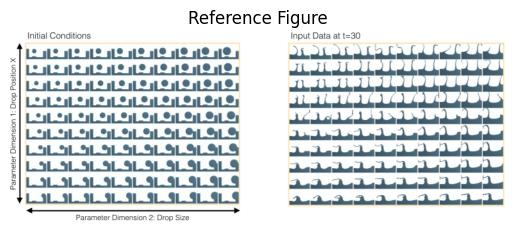


--- MISTRAL DECISION ---
{
  "needs_vision": true,
  "sub_question": "What are the specific ranges or values for \u03b11 (position of the liquid drop along x) and \u03b12 (size of the liquid drop) in each simulation shown in the left image?",
  "partial_answer": ""
}


In [ ]:
## LLM Reasoning
import pandas as pd
import os
from openai import OpenAI
import json
import re
from PIL import Image
import matplotlib.pyplot as plt

# === Setup ===
IMAGE_FOLDER= "../../../../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"
CSV_PATH = "../../../../Data/VisDoM-main/spiqa/spiqa.csv"


# === Load Mistral Client ===
client = OpenAI(base_url="http://127.0.0.1:1234/v1", api_key="lm-studio")

# === Mistral Decision Function ===
def mistral_decide(caption, question):
    prompt = f"""
You are a scientific assistant. Your job is to determine whether answering the following question requires looking at a figure or table or other visual reference in the paper.

If vision is needed, generate a clear sub-question you would ask your visual assistant (like "What does Figure 4 show for the value?" or "What is the trend in the graph?").

Caption:
{caption}

Question:
{question}

Respond in JSON:
{{
  "needs_vision": true/false,
  "sub_question": "What question should be asked of the visual component?",
  "partial_answer": "If no vision is needed, give the partial answer here."
}}
"""
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=700,
    )

    content = response.choices[0].message.content.strip()
    content = re.sub(r"```json|```", "", content).strip()
    match = re.search(r"\{.*?\}", content, re.DOTALL)
    if not match:
        raise ValueError(f"Could not extract JSON:\n{content}")
    
    json_str = match.group()
    json_str = re.sub(r'(?<!\\)\\(?![\\nrt"\\/bfu])', r'\\\\', json_str)

    return json.loads(json_str)

# === Load 1 sample ===
df = pd.read_csv(CSV_PATH)
sample = df.iloc[117]  # change index here for different rows

caption = sample["caption"]
question = sample["old_question"] if "old_question" in sample else sample["question"]
image_path = os.path.join(IMAGE_FOLDER, sample["doc_id"], sample["reference_figure"])

# === Display Question, Caption, and Image ===
print("\n--- QUESTION ---\n", question)
print("\n--- CAPTION ---\n", caption)

if os.path.exists(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Reference Figure")
    plt.show()
else:
    print("Image not found:", image_path)
    
# === Run Reasoning ===
try:
    decision = mistral_decide(caption, question)
    print("\n--- MISTRAL DECISION ---")
    print(json.dumps(decision, indent=2))
except Exception as e:
    print("Failed to parse Mistral output:", e)



--- QUESTION ---
 Referring to Table 4 in the MultiNLI paper, how does the ESIM model's test set accuracy change on SNLI, as well as on matched and mismatched MNLI genres, when trained on MNLI alone versus when trained on both MNLI and SNLI combined?

--- CAPTION ---
 Table 4: Test set accuracies (%) for all models; Match. represents test set performance on the MultiNLI genres that are also represented in the training set, Mis. represents test set performance on the remaining ones; Most freq. is a trivial ‘most frequent class’ baseline.


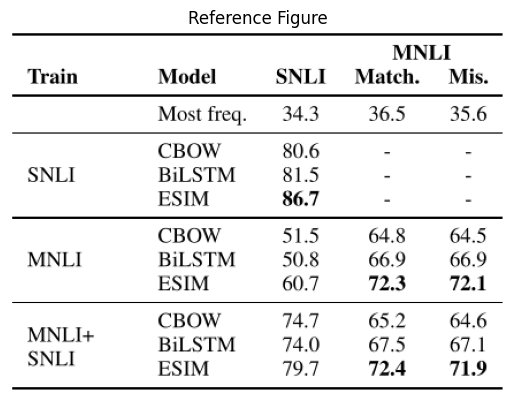


--- MISTRAL DECISION ---
{
  "needs_vision": true,
  "sub_question": "For the ESIM model, what are its test set accuracies (%) on SNLI, matched MNLI genres, and mismatched MNLI genres when trained on MNLI alone and when trained on both MNLI and SNLI combined?",
  "partial_answer": ""
}


In [95]:
# === Load 1 sample ===
df = pd.read_csv(CSV_PATH)
sample = df.iloc[117]  # change index here for different rows

caption = sample["caption"]
question = sample["old_question"] if "old_question" in sample else sample["question"]
image_path = os.path.join(IMAGE_FOLDER, sample["doc_id"], sample["reference_figure"])

# === Display Question, Caption, and Image ===
print("\n--- QUESTION ---\n", question)
print("\n--- CAPTION ---\n", caption)

if os.path.exists(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Reference Figure")
    plt.show()
else:
    print("Image not found:", image_path)
# === Run Reasoning ===
try:
    decision = mistral_decide(caption, question)
    print("\n--- MISTRAL DECISION ---")
    print(json.dumps(decision, indent=2))
except Exception as e:
    print("Failed to parse Mistral output:", e)